Note - this is following Jose Portilla, plus my additional code to clarify my understanding

#### Import library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Import dataset

In [2]:
#hearing tests
df = pd.read_csv('hearing_test.csv')
df

,age,physical_score,test_result
0,33.0,40.7,1
1,50.0,37.2,1
2,52.0,24.7,0
3,56.0,31.0,0
4,35.0,42.9,1
...,...,...,...
4995,73.0,3.9,0
4996,57.0,33.9,1
4997,49.0,34.5,1
4998,38.0,46.4,1


In [3]:
df['test_result'].value_counts() 
#3000 passed the hearing test, 2000 did not pass

1    3000
0    2000
Name: test_result, dtype: int64

<AxesSubplot:xlabel='age', ylabel='physical_score'>

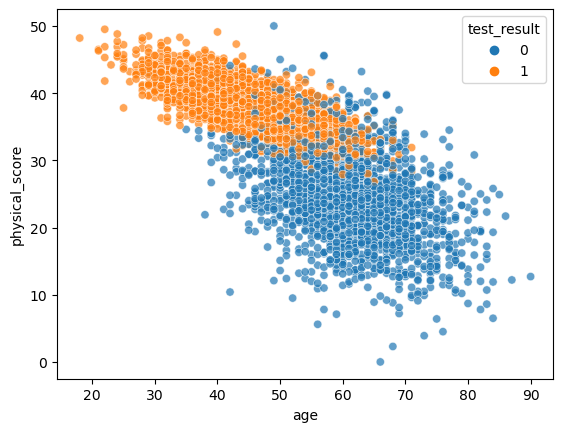

In [4]:
sns.scatterplot(data = df, x='age', y='physical_score', hue='test_result', alpha=0.7) 

#### Separate X features & y labels

In [5]:
X = df.drop('test_result', axis=1)
y = df['test_result']

#### Split Training/Test

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

#### Feature Scaling (Standard Scaler)

In [7]:
from sklearn.preprocessing import StandardScaler # not a bad idea to scale
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

#### Train the model

In [8]:
from sklearn.svm import SVC  # Support Vector Classifier (with Soft Margins)
model = SVC(kernel='rbf', C=1.0) #default values #SVM use kernels to project data to higher dimension to separate the data
model.fit(scaled_X_train, y_train)

SVC()

#### Test the model

In [9]:
y_pred = model.predict(scaled_X_test)
new_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
new_df.sample(5)

,y_test,y_pred
1866,0,0
2142,0,0
497,1,1
4222,0,0
3909,0,0


#### Evaluate the model

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

#model.coef_ ----note only available on linear kernel

print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')
print(f"Precision Score: {precision_score(y_test, y_pred)}")
print(f"Recall Score: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")

Accuracy Score: 0.948
Precision Score: 0.934984520123839
Recall Score: 0.9837133550488599
F1 Score: 0.9587301587301587


C:\Users\btemo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


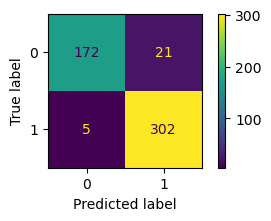

In [11]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, scaled_X_test, y_test).figure_.set_size_inches(4, 2)

In [12]:
confusion_matrix(y_test, y_pred)

array([[172,  21],
       [  5, 302]], dtype=int64)

In [13]:
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report # this breaks down the metrics by class 

,precision,recall,f1-score,support
0,0.971751,0.891192,0.929730,193.000
1,0.934985,0.983713,0.958730,307.000
accuracy,0.948000,0.948000,0.948000,0.948
macro avg,0.953368,0.937453,0.944230,500.000
weighted avg,0.949177,0.948000,0.947536,500.000


#### Visualize

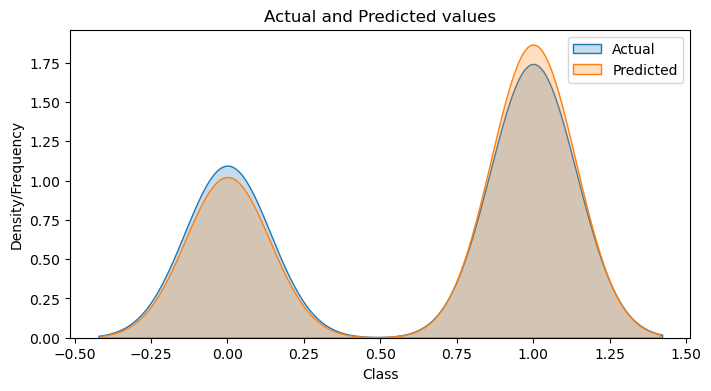

In [14]:
plt.figure(figsize=(8, 4))

sns.kdeplot(y_test, label='Actual', shade=True)
sns.kdeplot(y_pred, label='Predicted', shade=True)

plt.title('Actual and Predicted values')
plt.xlabel('Class')
plt.ylabel('Density/Frequency')
plt.legend()
plt.show()

# y_test & y_pred largely overlap, thus the predictions are closely aligned with the actual values.

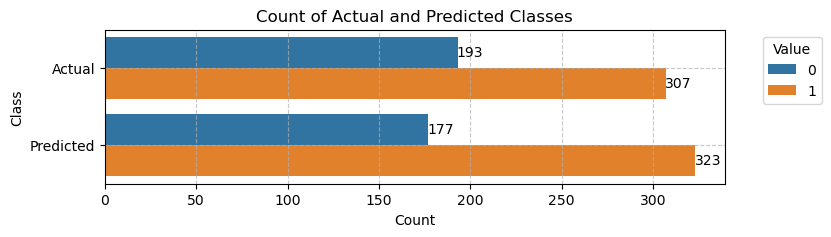

In [15]:
# Combine y_test and y_pred into a single DataFrame
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plot the counts of each class
plt.figure(figsize=(8, 2))
plot = sns.countplot(y='variable', hue='value', data=pd.melt(comparison_df))

# Add counts on top of the bars
for p in plot.patches:
    plot.annotate(format(p.get_width(), '.0f'), 
                  (p.get_width(), p.get_y() + p.get_height() / 2.), 
                  ha = 'center', va = 'center', 
                  xytext = (9, 0), 
                  textcoords = 'offset points')

plt.legend(title='Value', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Count of Actual and Predicted Classes')
plt.ylabel('Class')
plt.xlabel('Count')
plt.show()

#### Predict future patient

In [16]:
model.predict(scaler.transform([[33, 40]]))
#if patient is age 33 and has physical score of 40, then they will pass the hearing test

C:\Users\btemo\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([1], dtype=int64)

#### Grid Search with Cross Validation

OK so what is a good kernel or the number of C? Lets do Grid Search let the computer do the work instead of spending time and testing bunch.

In [17]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
svm = SVC()
param_grid = {'C': [0.01, 0.1, 1], 
             'kernel':['linear', 'rbf']}

grid = GridSearchCV(svm, param_grid)
grid.fit(X, y)
grid.best_params_

#and the default values are just as fine

{'C': 1, 'kernel': 'rbf'}

#### Lets Explore different Kernels

In [18]:
df = pd.read_csv('mouse_viral_study.csv')
df

,Med_1_mL,Med_2_mL,Virus Present
0,6.508231,8.582531,0
1,4.126116,3.073459,1
2,6.427870,6.369758,0
3,3.672953,4.905215,1
4,1.580321,2.440562,1
...,...,...,...
395,2.884122,3.271748,1
396,7.290855,9.488672,0
397,7.895325,8.272529,0
398,2.690592,2.674979,1


In [19]:
import warnings
warnings.filterwarnings('ignore')

# Source Code from https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html
def plot_svm_boundary(model,X,y):
    
    X = X.values
    y = y.values
    
    # Scatter Plot
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30,cmap='seismic')

    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')
    plt.show()

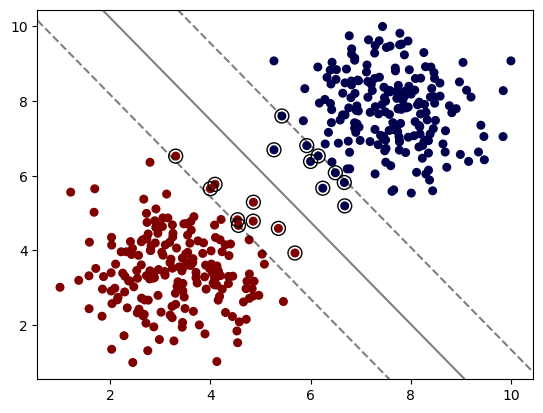

In [20]:
#just Visualize it the Hyperplane & Support Vectors

from sklearn.svm import SVC
X = df.drop('Virus Present', axis=1)
y = df['Virus Present']
model = SVC(kernel='linear', C=0.05) 
# as C gets smaller than we are allowing more points to go within the margin. What is the optimal number for C?
model.fit(X, y)

plot_svm_boundary(model, X, y)

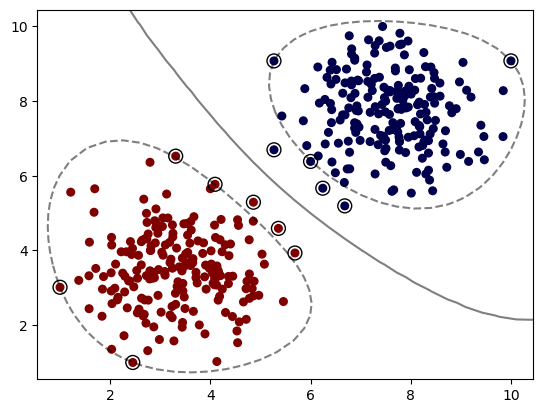

In [21]:
model = SVC(kernel='rbf', C=1, gamma = 'scale') 
model.fit(X, y)
plot_svm_boundary(model, X, y)

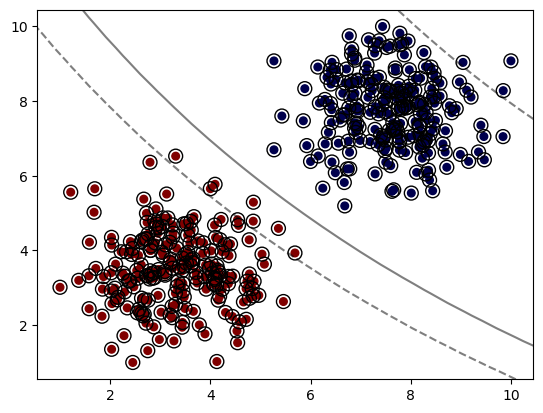

In [22]:
model = SVC(kernel='sigmoid')   #not recommended as points are within support vectors and hyperplane
model.fit(X, y)
plot_svm_boundary(model, X, y)

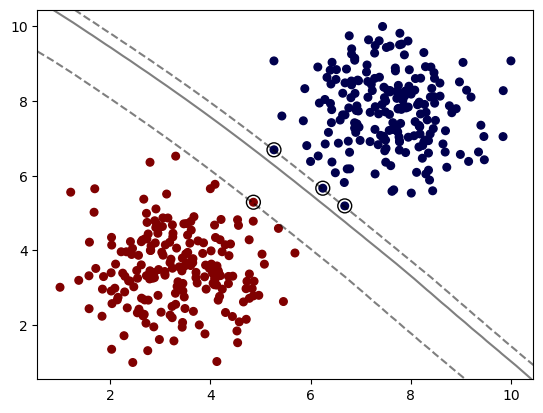

In [23]:
model = SVC(kernel='poly', degree=20) #it can be curvy
model.fit(X, y)
plot_svm_boundary(model, X, y)